In [80]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [81]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
from tqdm import tnrange, tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 5
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  5
Current device:  5


In [87]:
DATA_PATH = '../../data/agent-benchmark'
TRAIN_DATASET = os.path.join(DATA_PATH, 'train.csv')
VAL_DATASET = os.path.join(DATA_PATH, 'val.csv')
TEST_DATASET  = os.path.join(DATA_PATH, 'test.csv')

In [88]:
LM_PATH=Path('../../models/ulmfit/lm/twitter-en')
LM_PATH.mkdir(exist_ok=True)

In [89]:
def read_data(filename):
    data = pd.read_csv(filename, sep=";", names =['utterance','label'], header=None, dtype={'utterance':str, 'label': str} )
    return data

In [90]:
train_dataset = read_data(TRAIN_DATASET).dropna()
val_dataset = read_data(VAL_DATASET).dropna()
test_dataset = read_data(TEST_DATASET).dropna()

In [91]:
tokenizer = Tokenizer(lang='en', n_cpus=10)

In [92]:
data_lm = TextLMDataBunch.from_df(LM_PATH, train_df = train_dataset, valid_df = val_dataset,  bs=128, text_cols=0)

In [93]:
weights_pretrained = 'tweets-en-30k-lm-step4-best'
itos_pretrained = 'tweets_en_lm_30k_itos_vocab'
pretained_data = (weights_pretrained, itos_pretrained)

In [103]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=pretained_data, pretrained=False, drop_mult=0.4, callback_fns=ShowGraph)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01


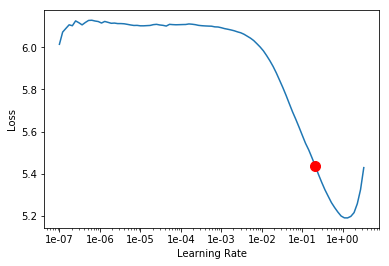

In [95]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,6.067546,5.424788,0.149219,00:02
1,5.521550,4.336784,0.261830,00:02
2,5.009984,3.860590,0.318304,00:02
3,4.581547,3.667623,0.338728,00:02
4,4.268157,3.578147,0.344531,00:02
5,4.044318,3.545285,0.346540,00:02
6,3.896308,3.539961,0.348214,00:02


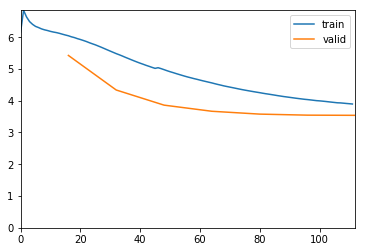

Better model found at epoch 0 with val_loss value: 5.424788475036621.
Better model found at epoch 1 with val_loss value: 4.3367838859558105.
Better model found at epoch 2 with val_loss value: 3.8605895042419434.
Better model found at epoch 3 with val_loss value: 3.6676225662231445.
Better model found at epoch 4 with val_loss value: 3.5781466960906982.
Better model found at epoch 5 with val_loss value: 3.5452847480773926.
Better model found at epoch 6 with val_loss value: 3.539961338043213.


In [104]:
learn.fit_one_cycle(7, 1E-2, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-FT-agent-benchmark-head-best')])

In [ ]:
learn.load('tweets-en-25k-FT-agent-benchmark-head-best') 

epoch,train_loss,valid_loss,accuracy,time
0,3.454523,3.330768,0.362221,00:03
1,3.290497,3.201487,0.377846,00:03
2,3.101746,3.152594,0.382701,00:03
3,2.913609,3.137646,0.386496,00:03
4,2.753238,3.154669,0.389788,00:03


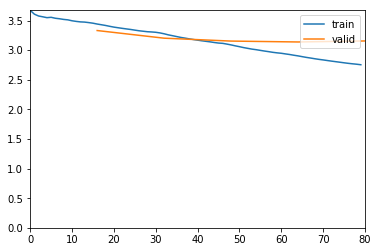

Better model found at epoch 0 with val_loss value: 3.330768346786499.
Better model found at epoch 1 with val_loss value: 3.2014870643615723.
Better model found at epoch 2 with val_loss value: 3.1525936126708984.
Better model found at epoch 3 with val_loss value: 3.137646198272705.


In [106]:
learn.unfreeze()
learn.fit_one_cycle(5,  5E-03, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-FT-agent-benchmark-step2-best')])

In [107]:
np.exp(3.137646)

23.049544318851044

In [ ]:
learn.load('tweets-en-25k-FT-agent-benchmark-step2-best')

In [109]:
learn.save_encoder('tweets-en-25k-FT-agent-benchmark-encoder')

In [110]:
!cp ../../models/ulmfit/lm/twitter-en/models/tweets-en-25k-FT-agent-benchmark-encoder.pth models/

In [111]:
learn.predict('please  ', 3)

'please   enter the email'

In [112]:
data_class = TextClasDataBunch.from_df(path = "", train_df = train_dataset, valid_df = val_dataset, test_df = test_dataset,  vocab=data_lm.train_ds.vocab,tokenizer=tokenizer, bs=128, text_cols=['utterance'], label_cols=['label'])

In [115]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5, callback_fns=ShowGraph)
learn.load_encoder('tweets-en-25k-FT-agent-benchmark-encoder')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


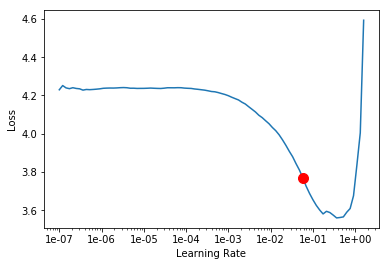

In [116]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,2.023107,1.473188,0.595017,00:04
1,1.718889,1.365911,0.622374,00:04
2,1.683925,1.341965,0.627748,00:04
3,1.623058,1.308368,0.631656,00:04
4,1.558791,1.237787,0.647289,00:04
5,1.488084,1.140758,0.684416,00:04
6,1.430857,1.113765,0.694675,00:04
7,1.348491,1.089823,0.705423,00:04
8,1.318234,1.039136,0.715681,00:04
9,1.241683,1.037840,0.720078,00:04


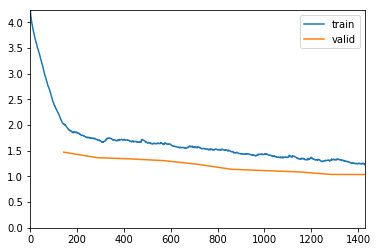

Better model found at epoch 0 with val_loss value: 1.4731876850128174.
Better model found at epoch 1 with val_loss value: 1.3659108877182007.
Better model found at epoch 2 with val_loss value: 1.341964840888977.
Better model found at epoch 3 with val_loss value: 1.3083676099777222.
Better model found at epoch 4 with val_loss value: 1.2377872467041016.
Better model found at epoch 5 with val_loss value: 1.1407577991485596.
Better model found at epoch 6 with val_loss value: 1.113765001296997.
Better model found at epoch 7 with val_loss value: 1.0898233652114868.
Better model found at epoch 8 with val_loss value: 1.0391359329223633.
Better model found at epoch 9 with val_loss value: 1.0378397703170776.


In [117]:
learn.fit_one_cycle(10, 5E-2, moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-FT-agent-benchmark-classifier-head-best')])

In [ ]:
learn.load('tweets-en-25k-FT-agent-benchmark-classifier-head-best')

epoch,train_loss,valid_loss,accuracy,time
0,1.284343,0.991826,0.725452,00:04
1,1.099689,0.953775,0.736688,00:04


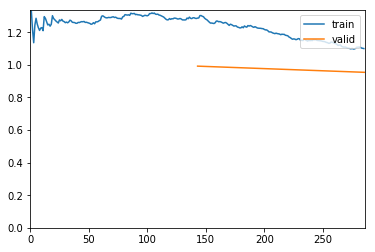

Better model found at epoch 0 with val_loss value: 0.9918259978294373.
Better model found at epoch 1 with val_loss value: 0.9537747502326965.


In [119]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1E-2/(2.6**4),1E-2), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-FT-agent-benchmark-classifier-step2-best')])


In [ ]:
learn.load('tweets-en-25k-FT-agent-benchmark-classifier-step2-best')

epoch,train_loss,valid_loss,accuracy,time
0,1.058416,0.937152,0.740107,00:06
1,0.979025,0.883562,0.754275,00:05
2,0.866114,0.853845,0.774304,00:05
3,0.725289,0.840671,0.780166,00:06


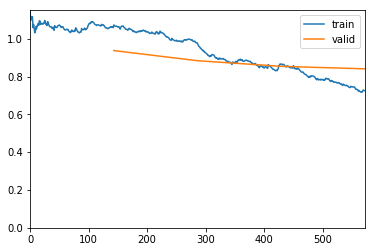

Better model found at epoch 0 with val_loss value: 0.9371519684791565.
Better model found at epoch 1 with val_loss value: 0.8835616111755371.
Better model found at epoch 2 with val_loss value: 0.8538448810577393.
Better model found at epoch 3 with val_loss value: 0.8406707644462585.


In [121]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(8E-3/(2.6**4),8E-3), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-FT-agent-benchmark-classifier-step3-best')])


In [ ]:
learn.load('tweets-en-25k-FT-agent-benchmark-classifier-step3-best')

epoch,train_loss,valid_loss,accuracy,time
0,0.745019,0.847757,0.771861,00:07
1,0.715903,0.826752,0.785051,00:07
2,0.658012,0.833296,0.776746,00:07
3,0.569085,0.834841,0.781143,00:07


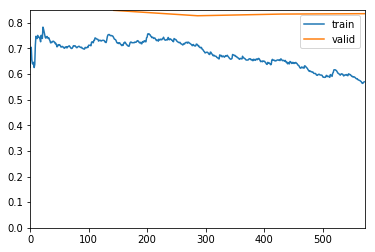

Better model found at epoch 0 with val_loss value: 0.8477574586868286.
Better model found at epoch 1 with val_loss value: 0.8267515301704407.


In [123]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(4e-3/(2.6**4),4e-3), moms=(0.8,0.7), callbacks=[ShowGraph(learn), SaveModelCallback(learn, name='tweets-en-25k-FT-agent-benchmark-classifier-step4-best')])

In [ ]:
learn.load('tweets-en-25k-FT-agent-benchmark-classifier-step4-best')

In [125]:
y = []
for item in test_dataset.itertuples():
    label = item[2]
    label_id = learn.data.classes.index(label)
    y.append(label_id)

In [126]:
preds_test = learn.get_preds(ds_type = DatasetType.Test, ordered=True)

In [127]:
y_hat = torch.argmax(preds_test[0], dim=1)

In [128]:
from sklearn.metrics import classification_report
print(classification_report(y, y_hat, target_names=learn.data.classes, digits=3))

                           precision    recall  f1-score   support

             IOT_cleaning      0.978     0.938     0.957        48
               IOT_coffee      0.918     0.900     0.909        50
                  IOT_hue      0.910     0.949     0.929       214
                 IOT_wemo      0.833     0.854     0.843        41
             QA_celebrity      0.748     0.796     0.771       108
            QA_definition      0.866     0.887     0.876       124
               QA_factoid      0.756     0.779     0.768       195
                 QA_maths      0.780     0.842     0.810        38
            QA_open_query      0.551     0.408     0.469       120
                 QA_stock      0.849     0.900     0.874        50
              alarm_query      0.683     0.757     0.718        37
             alarm_remove      0.781     0.625     0.694        40
                alarm_set      0.782     0.896     0.835        48
               audio_mute      0.610     0.658     0.633     